Pablo Gómez, Tingqu Zhou, David Malone

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

In [3]:
df=pd.read_csv("QRM-2022-cw2-data.csv")

In [4]:
#first calculate log returns
df['simplereturn']=df['TSLA'].pct_change()
#log returns
df['logreturn']=np.log(1+df['simplereturn'])*100

#Convert to percentage values
df['simplereturn']=df['simplereturn']*100
df['linloss']=df['logreturn']*(-1)

In [5]:
df_shift=df.copy()
df_shift=df_shift.loc[1:].reset_index()
df_shift['Date']=pd.to_datetime(df_shift['Date'])

In [6]:
df_shift

,index,Date,TSLA,simplereturn,logreturn,linloss
0,1,2012-11-27,2.143333,-0.371862,-0.372556,0.372556
1,2,2012-11-28,2.215333,3.359254,3.304064,-3.304064
2,3,2012-11-29,2.246000,1.384307,1.374813,-1.374813
3,4,2012-11-30,2.254667,0.385886,0.385143,-0.385143
4,5,2012-12-03,2.308000,2.365449,2.337906,-2.337906
...,...,...,...,...,...,...
2513,2514,2022-11-18,180.190002,-1.626902,-1.640281,1.640281
2514,2515,2022-11-21,167.869995,-6.837231,-7.082202,7.082202
2515,2516,2022-11-22,169.910004,1.215231,1.207907,-1.207907
2516,2517,2022-11-23,183.199997,7.821784,7.530953,-7.530953


In [7]:
#split data set
splitdate=pd.to_datetime("2021-11-26")
train_data=df_shift[df_shift['Date']<splitdate]
test_data=df_shift[df_shift['Date']>=splitdate]

In [8]:
test_data

,index,Date,TSLA,simplereturn,logreturn,linloss
2266,2267,2021-11-26,360.640015,-3.053759,-3.101358,3.101358
2267,2268,2021-11-29,378.996674,5.090023,4.964716,-4.964716
2268,2269,2021-11-30,381.586670,0.683382,0.681058,-0.681058
2269,2270,2021-12-01,365.000000,-4.346763,-4.444065,4.444065
2270,2271,2021-12-02,361.533325,-0.949774,-0.954313,0.954313
...,...,...,...,...,...,...
2513,2514,2022-11-18,180.190002,-1.626902,-1.640281,1.640281
2514,2515,2022-11-21,167.869995,-6.837231,-7.082202,7.082202
2515,2516,2022-11-22,169.910004,1.215231,1.207907,-1.207907
2516,2517,2022-11-23,183.199997,7.821784,7.530953,-7.530953


# (i)

In [10]:
!pip install arch

In [11]:
from arch.univariate import arch_model

In [12]:
#Fit a Garch(1,1) model to the training data
#using conditional constant mean and standard normal errors
model=arch_model(train_data['linloss'],mean="constant",p=1,q=1,dist="normal")
res=model.fit(update_freq=1)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 109978.20172635719
Iteration:      2,   Func. Count:     14,   Neg. LLF: 7646.948234699395
Iteration:      3,   Func. Count:     20,   Neg. LLF: 5878.970866188358
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5902.872166434865
Iteration:      5,   Func. Count:     32,   Neg. LLF: 5882.501442552712
Iteration:      6,   Func. Count:     38,   Neg. LLF: 5864.24811389964
Iteration:      7,   Func. Count:     44,   Neg. LLF: 5926.802477181402
Iteration:      8,   Func. Count:     51,   Neg. LLF: 5896.343936517011
Iteration:      9,   Func. Count:     57,   Neg. LLF: 5854.909254438066
Iteration:     10,   Func. Count:     62,   Neg. LLF: 5854.909119613392
Iteration:     11,   Func. Count:     67,   Neg. LLF: 5854.909118900386
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5854.909118900386
            Iterations: 11
            Function evaluations: 67
            Gradient evaluations: 11

In [13]:
print(res)

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                linloss   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5854.91
Distribution:                  Normal   AIC:                           11717.8
Method:            Maximum Likelihood   BIC:                           11740.7
                                        No. Observations:                 2266
Date:                Wed, Dec 04 2024   Df Residuals:                     2265
Time:                        13:07:29   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu            -0.1506  6.417e-02     -2.347  1.891e-02 [ -0.2

In [14]:
#analyse the standardised residuals
std_resid=np.asarray(res.std_resid)

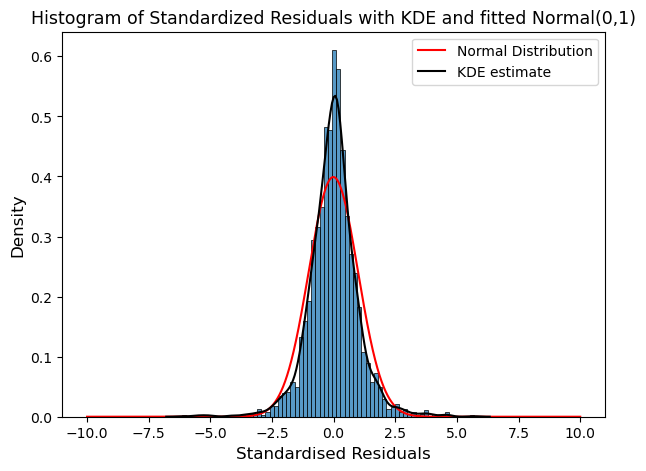

In [15]:
plt.figure(figsize=(7,5),dpi=100)
plt.title("Histogram of Standardized Residuals with KDE and fitted Normal(0,1)",size=12.5)
n=len(std_resid)
sns_hist=sns.histplot(std_resid,bins=int(70),stat="density")

#now fit the normal distribution with standardized residual mean and standard deviation
mu=np.mean(std_resid)
sd=np.sqrt(np.var(std_resid,ddof=1))
plt.xlabel("Standardised Residuals",size=12)
plt.ylabel("Density",size=12)
x=np.linspace(-10,10,5000)
sns_hist.plot(x,stats.norm.pdf(x,mu,sd),label="Normal Distribution",color="red")
sns.kdeplot(std_resid,color="black",label="KDE estimate")
plt.legend()
plt.show()

The standardized residuals are centered around 0, they do not appear to be normally distributed, as the histogram of the residuals has a much narrower peak, and slightly heavier tails. This suggests that it deviates from the mean less frequently than the normal distribution, but has a slightly higher likelihood of observing extreme values far from the mean.

We also note that the graph is slightly negatively skewed, it has a heavier left tail.

In [18]:
stats.skew(std_resid)

-0.08107105315428938

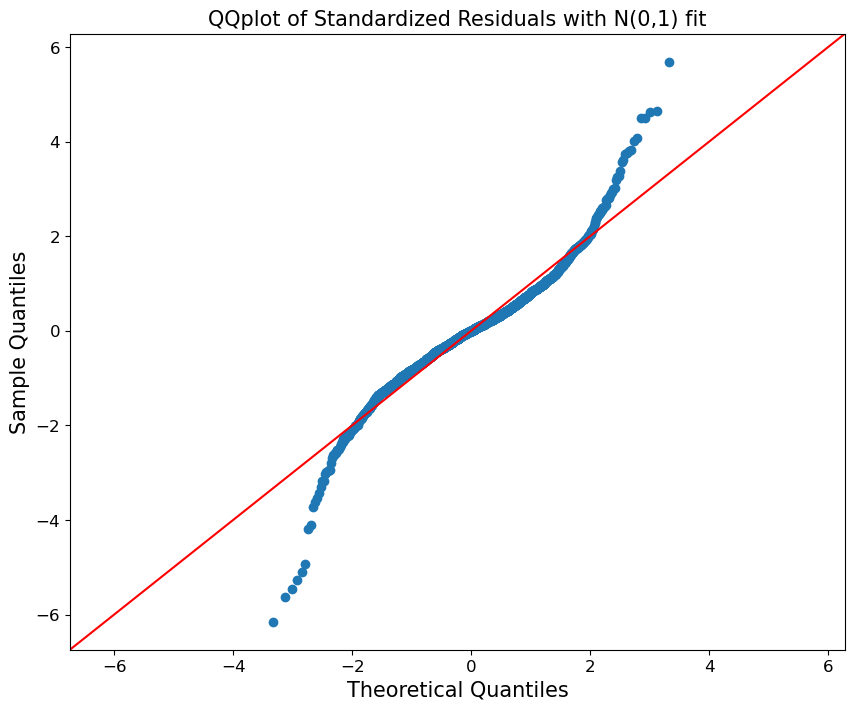

In [19]:
#QQplots
fig, ax = plt.subplots(figsize=(10, 8))
sm.qqplot(std_resid, line='45',ax=ax) 
plt.title("QQplot of Standardized Residuals with N(0,1) fit",size=15)
plt.xlabel("Theoretical Quantiles",size=15)
plt.ylabel("Sample Quantiles",size=15)
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

Similar to the histogram it is quite clear that the standardized residuals are not normally distributed. We see significant departures from the line at most points. The points oscillate about the line at the 0th quantile, corresponding to the narrow peak in the histogram vs the normal distribution. Similarly we see significant departures from the line at the tails, corresponding to the slight heavier tails on the histogram than would be implied by the normal distribution.

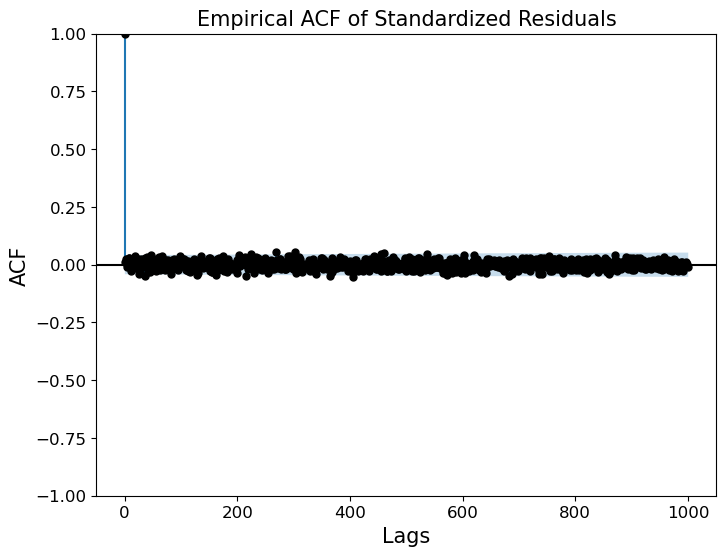

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
sm.graphics.tsa.plot_acf(std_resid,lags=1000,title="Empricial ACF of Standardized Residuals",ax=ax,color="black")
plt.title("Empirical ACF of Standardized Residuals",size=15)
plt.xlabel("Lags",size=15)
plt.ylabel("ACF",size=15)
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

After the first lag, the autocorrelation function is very close to 0 at each lag. This suggests that there is no correlation between the standardized residuals at different lags. In other words they are independent, and appear similar to a white noise process.

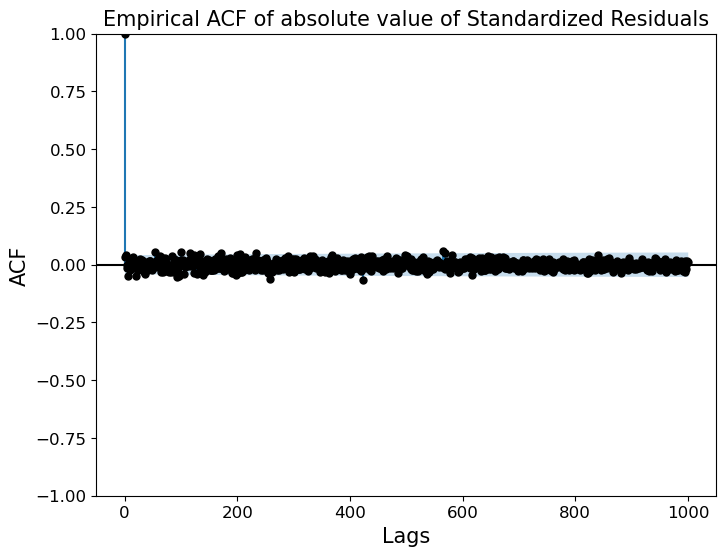

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
sm.graphics.tsa.plot_acf(np.abs(std_resid),lags=1000,title="Empricial ACF of absolute value of Standardized Residuals",ax=ax,color="black")
plt.title("Empirical ACF of absolute value of Standardized Residuals",size=15)
plt.xlabel("Lags",size=15)
plt.ylabel("ACF",size=15)
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

Similar to the first ACF of the standardized residuals, there are no significant lags other than the first one. Which again indicates that there is no correlation or dependence between the standardized residuals.

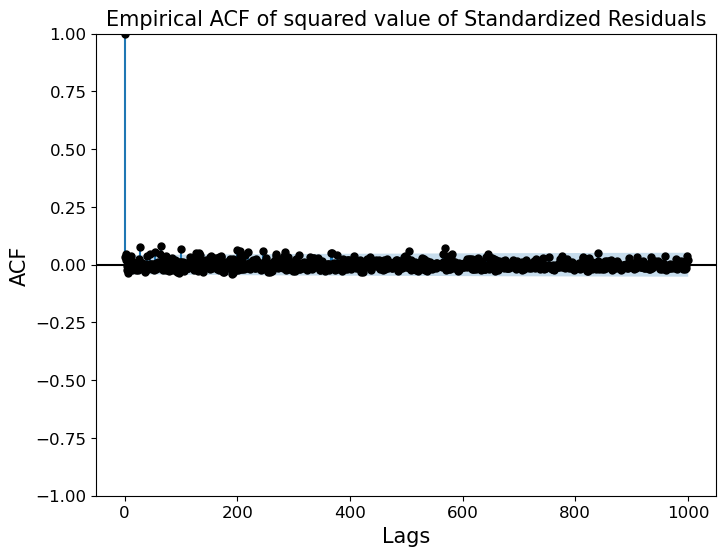

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))
sm.graphics.tsa.plot_acf(std_resid**2,lags=1000,title="Empricial ACF of squared value of Standardized Residuals",ax=ax,color="black")
plt.title("Empirical ACF of squared value of Standardized Residuals",size=15)
plt.xlabel("Lags",size=15)
plt.ylabel("ACF",size=15)
plt.yticks(size=12)
plt.xticks(size=12)
plt.show()

From the ACF plot of the square of the standardized residuals we can see that almost all lags are not significant, there are a small number that are significant, however it is possible that this is simply by chance due to noise in the data. Even when they are significant, they are only minimally correlated. It is not enough evidence to conclude that there is a serial correlation between the residuals.

Ultimately the residuals appear to be independently identically distributed.


## (ii)

In [29]:
from scipy.stats import t

In [30]:
print(stats.t.fit(std_resid))
#estimate the parameter fit

(3.560147359752372, -0.014173871257913296, 0.6858888680637825)


Standardized residual mean: -0.012741008632824534
Standardized residual std: 0.999448839130981


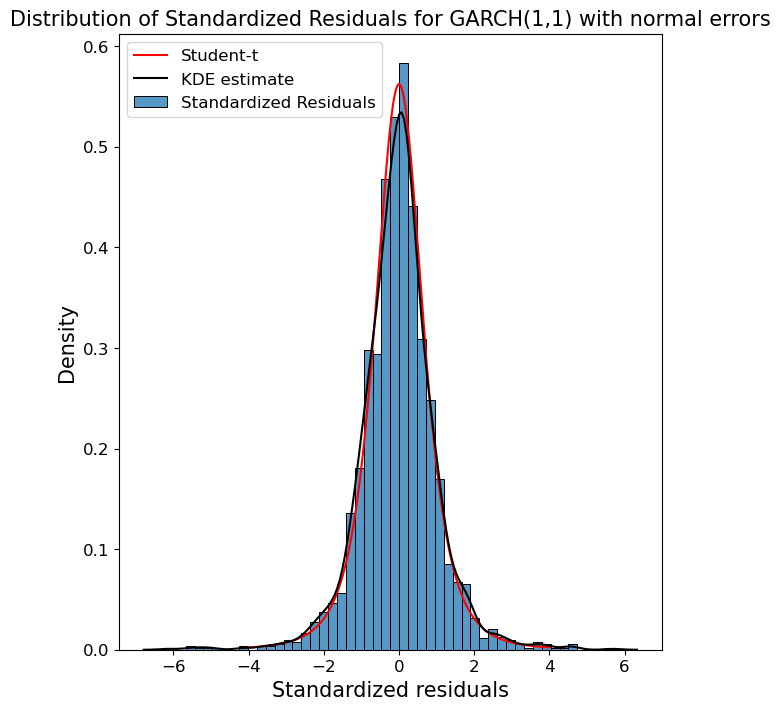

In [31]:
# fit a normalised student t-distribution to the standardized residuals from i
df=stats.t.fit(std_resid,floc=0)[0]

print("Standardized residual mean: "+str(np.mean(std_resid)))
print("Standardized residual std: "+str(np.std(std_resid)))

scale=np.sqrt((df-2)/df)
#loc=-np.mean(std_resid) #location parameter
plt.figure(figsize=(7,8))
t_x=np.linspace(-4,4,len(x))
sns_ax=sns.histplot(data=std_resid,bins=50,stat="density",label="Standardized Residuals")
sns_ax.plot(t_x,stats.t.pdf(t_x,df=df,scale=scale),label="Student-t",color="red")
sns.kdeplot(std_resid,color="black",label="KDE estimate")


plt.xlabel("Standardized residuals",size=15)
plt.ylabel("Density",size=15)
plt.title("Distribution of Standardized Residuals for GARCH(1,1) with normal errors",size=15)
plt.legend(prop={'size': 12})
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

In [32]:
print(df)
print(scale)

3.559260687859319
0.6618803164638942


The standardised student-t distribution with 4 degrees of freedom seems to fit the residuals quite well. The narrow peak and slightly heavier tails are better captured by this distribution. So we suspect that such a student-t distribution would be a good fit for the residuals.

We can assess this also using a QQ-plot

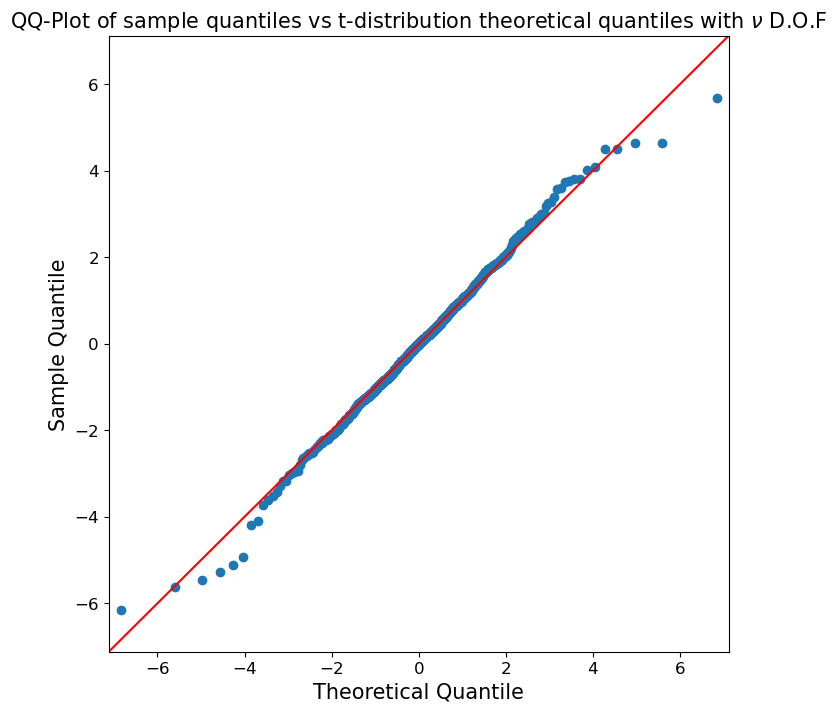

In [34]:
fig, ax = plt.subplots(figsize=(8, 8))

sm.qqplot(std_resid,dist=stats.t,distargs=([df]),scale=scale,line='45',ax=ax)
plt.title("QQ-Plot of sample quantiles vs t-distribution theoretical quantiles with "+ '$\\nu$' +" D.O.F",size=15)
plt.ylabel("Sample Quantile",size=15)
plt.xlabel("Theoretical Quantile", size=15)
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

The distribution of the quantiles follows the line quite closely, so it is highly likely that the standardized residuals follows this standardized student-t distribution with $\nu$ degrees of freedom. However we do see some inconsistencies at the tails, this could imply that a better fit could be found. But since only a small number of points deviate from the line it is more likely that this is due to random chance or noise in the data.

## (iii)

In order to determine the cut-off to be used, lets first look at the mean excess plot

Text(0, 0.5, 'Mean Excess')

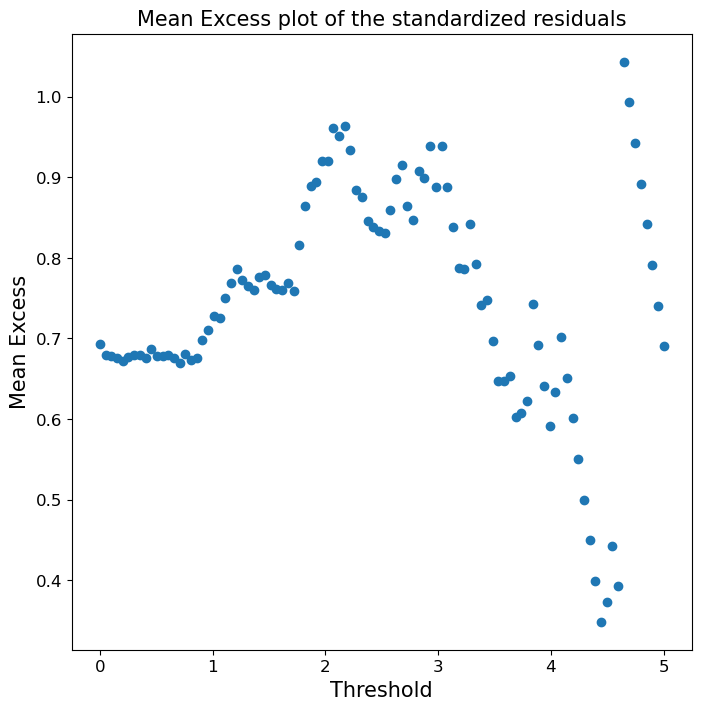

In [38]:
#fit the generalised pareto distribution to the standardised residuals
fig, ax = plt.subplots(figsize=(8, 8))

u=np.linspace(0,5,100) #set of potential cut offs
excess_mean=[]

for uu in u:
    excess_mean.append(np.sum((std_resid>uu)*(std_resid-uu))/np.sum(std_resid>uu))
plt.scatter(u,excess_mean)
plt.title("Mean Excess plot of the standardized residuals",size=15)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Threshold",size=15)
plt.ylabel("Mean Excess",size=15)

In [39]:
# choose our cut off of extreme values as u=1, we consider only the extreme values abovr this cut off

u=1
data_cutoff=pd.DataFrame(std_resid,columns=["std_resid"])
extreme_vals=data_cutoff[data_cutoff['std_resid']>u]
extreme_vals=extreme_vals.reset_index(drop=True)
extreme_vals

,std_resid
0,1.153362
1,2.526934
2,1.050499
3,1.057980
4,1.600289
...,...
242,1.124782
243,1.817459
244,1.518205
245,3.737025


In [40]:
#Now fit a generalised pareto distribution
#implement the log-likelihood function
y=np.asarray(extreme_vals-u)
def GPD_likelihood(y,xi,beta):
    n=len(y)
    return -n * np.log(beta) - (1+1/xi)* np.sum(np.log(1+xi*y/beta))

In [41]:
from scipy.optimize import minimize

In [42]:
objfun=lambda theta: -1*GPD_likelihood(y,theta[0],theta[1]) #multiply by -1 to turn this into a minimisation problem
theta0=[1,1]

print("Initial Objective function:",objfun(theta0))

bnds=[(0.001,20),(0.001,20)] #bounds are for xi and beta respectively

sol=minimize(objfun,theta0,method='SLSQP',bounds=bnds,options={'disp':True})

xi=sol.x[0]
beta=sol.x[1]

print("Estimate of xi is:",xi)
print("Estimate of Beta is",beta)

Initial Objective function: 233.01022977356297
Optimization terminated successfully    (Exit mode 0)
            Current function value: 169.15819608630824
            Iterations: 13
            Function evaluations: 46
            Gradient evaluations: 13
Estimate of xi is: 0.0857066785431854
Estimate of Beta is 0.6697482423753545


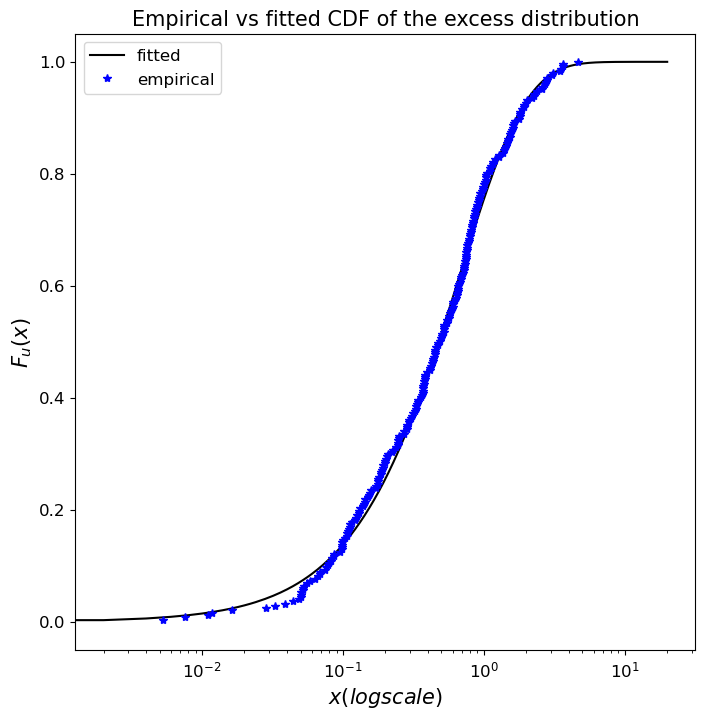

In [43]:
#Model fitting results
def GPD_CDF(x,xi,beta):
    if xi==0:
        return 1-np.exp(-x/beta)
    else:
        return 1-(1+xi*x/beta)**(-1/xi)
xx=np.linspace(0,20,10000)

#empirical cdf
emp_objcdf=sm.distributions.empirical_distribution.ECDF(y.flatten())

fig,ax=plt.subplots(figsize=(8,8))
ax.plot(xx,GPD_CDF(xx,xi,beta),'k-',label="fitted")
ax.plot(y,emp_objcdf(y),'b*',label="empirical")
ax.set_xscale('log')
ax.set_title('Empirical vs fitted CDF of the excess distribution',size=15)
ax.set_ylabel('$F_{u}(x)$',size=15)
ax.set_xlabel('$x (log scale)$',size=15)
ax.legend(prop={'size': 12})
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

# (iv)
## One n-day ahead forecast

Standard Normal

In [45]:
res

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                linloss   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5854.91
Distribution:                  Normal   AIC:                           11717.8
Method:            Maximum Likelihood   BIC:                           11740.7
                                        No. Observations:                 2266
Date:                Wed, Dec 04 2024   Df Residuals:                     2265
Time:                        13:07:29   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu            -0.1506  6.417e-02     -2.347  1.891e-02 [ -0.2

In [46]:
forecasts=res.forecast(horizon=252,reindex=False)

In [47]:
forecasts.variance

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.243,h.244,h.245,h.246,h.247,h.248,h.249,h.250,h.251,h.252
2265,14.187153,14.17245,14.157906,14.143519,14.129289,14.115212,14.101288,14.087515,14.073891,14.060415,...,12.927311,12.926258,12.925217,12.924186,12.923167,12.922159,12.921162,12.920175,12.919199,12.918234


In [48]:
var=np.var(train_data['linloss'],ddof=1)
mu=res.params[0]
alpha0=res.params[1]
alpha1=res.params[2]
beta1=res.params[3]
volatilities=np.zeros(len(df_shift))
volatilities[0]=var
for i in range(1,len(train_data)+1):
    volatilities[i]=alpha0+alpha1*(train_data['linloss'].iloc[i-1]-mu)**2+beta1*volatilities[i-1]

C:\Users\default.EliteBook\AppData\Local\Temp\ipykernel_9644\1750297425.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu=res.params[0]
C:\Users\default.EliteBook\AppData\Local\Temp\ipykernel_9644\1750297425.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha0=res.params[1]
C:\Users\default.EliteBook\AppData\Local\Temp\ipykernel_9644\1750297425.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha1=res.params[2]
C:\Us

In [49]:
#now implement the method for h steps ahead h>=2 by hand
for i in range( (len(train_data)+1) , (len(train_data) + len(test_data))):
    volatilities[i]=alpha0+alpha1*volatilities[i-1]+beta1*volatilities[i-1]

In [50]:
volatilities
#these predictions match up with the arch forecasts

array([12.15438906, 11.67526491, 11.61690362, ..., 12.92017519,
       12.91919945, 12.91823428])

Text(0, 0.5, 'Positive part of Linearised Losses (%)')

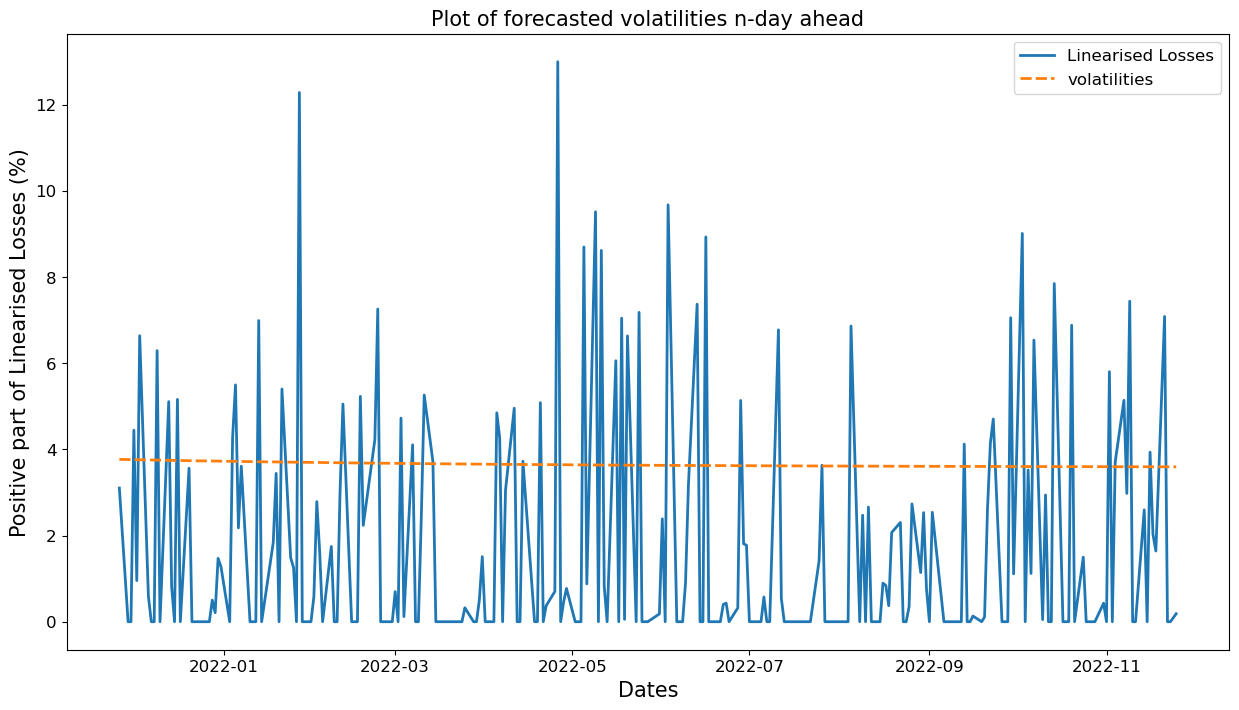

In [51]:
y=[i if i>0 else 0 for i in test_data['linloss']]
plt.figure(figsize=(15,8))
dates=test_data['Date'].to_numpy()
index = [pd.to_datetime(date, format='%m/%d/%Y').date() for date in dates]

df_to_plot=pd.DataFrame({"Linearised Losses":y,"volatilities":np.sqrt(volatilities[2266:])},index=index)
sns.lineplot(data=df_to_plot,linewidth=2)
plt.title("Plot of forecasted volatilities n-day ahead",size=15)
plt.legend(prop={'size': 12})
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Dates",size=15)
plt.ylabel("Positive part of Linearised Losses (%)",size=15)

In [52]:
#We assume that the residuals follow a standard normal distribution, so we can compute the quantiles directly
#new method of calculating ES
q95_norm=stats.norm.ppf(0.95)
q99_norm=stats.norm.ppf(0.99)

#ES
ZES95_norm=stats.norm.pdf(q95_norm)/(1-0.95)
ZES99_norm=stats.norm.pdf(q99_norm)/(1-0.99)

In [53]:
ZES95_norm

2.0627128075074257

In [54]:
#now calculate the VaR and ES forecasts for test data time frame
var95_norm=mu+np.sqrt(volatilities[2266:])*q95_norm
var99_norm=mu+np.sqrt(volatilities[2266:])*q99_norm
ES95_norm=mu+np.sqrt(volatilities[2266:])*ZES95_norm
ES99_norm=mu+np.sqrt(volatilities[2266:])*ZES99_norm

In [55]:
test_data

,index,Date,TSLA,simplereturn,logreturn,linloss
2266,2267,2021-11-26,360.640015,-3.053759,-3.101358,3.101358
2267,2268,2021-11-29,378.996674,5.090023,4.964716,-4.964716
2268,2269,2021-11-30,381.586670,0.683382,0.681058,-0.681058
2269,2270,2021-12-01,365.000000,-4.346763,-4.444065,4.444065
2270,2271,2021-12-02,361.533325,-0.949774,-0.954313,0.954313
...,...,...,...,...,...,...
2513,2514,2022-11-18,180.190002,-1.626902,-1.640281,1.640281
2514,2515,2022-11-21,167.869995,-6.837231,-7.082202,7.082202
2515,2516,2022-11-22,169.910004,1.215231,1.207907,-1.207907
2516,2517,2022-11-23,183.199997,7.821784,7.530953,-7.530953


Text(0, 0.5, 'Positive part of Linearised Losses (%)')

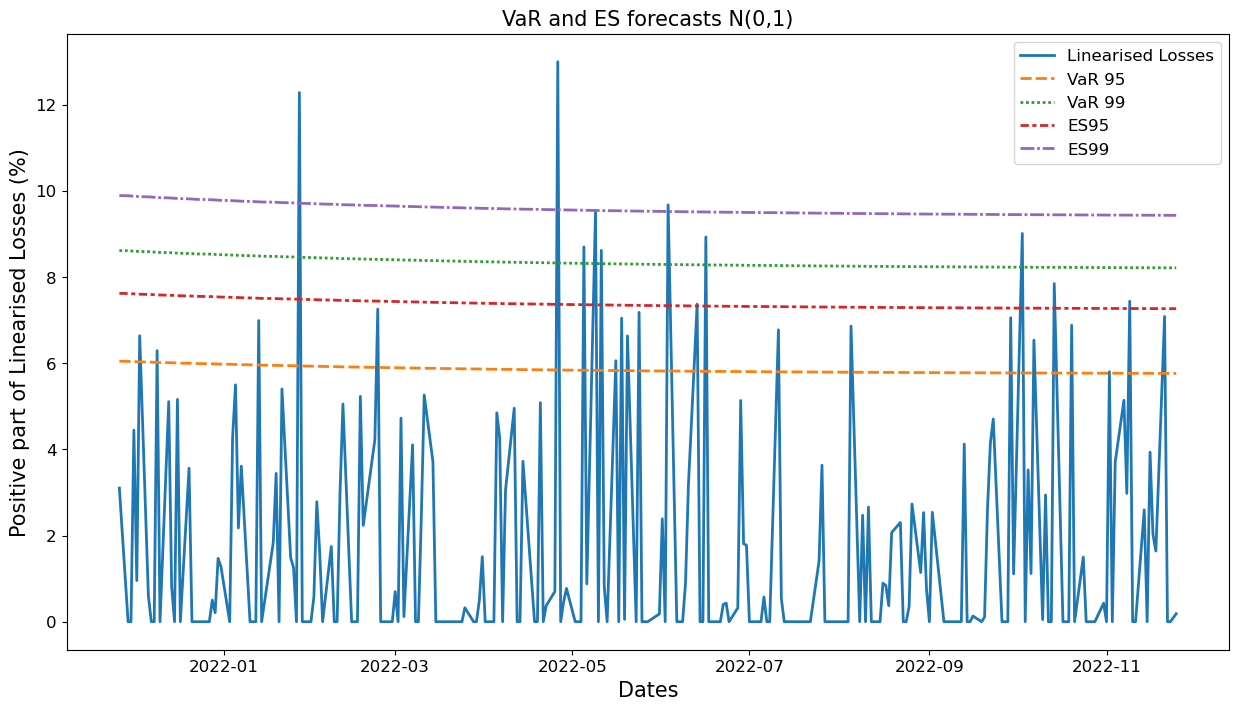

In [56]:
y=[i if i>0 else 0 for i in test_data['linloss']]

#set up dates for plot
dates=test_data['Date'].to_numpy()
index = [pd.to_datetime(date, format='%m/%d/%Y').date() for date in dates]



plt.figure(figsize=(15,8))
df_to_plot=pd.DataFrame({"Linearised Losses":y,"VaR 95":var95_norm,"VaR 99":var99_norm,"ES95":ES95_norm,"ES99":ES99_norm},
                        index=index)
sns.lineplot(data=df_to_plot,linewidth=2)
plt.title("VaR and ES forecasts N(0,1)",size=15)
plt.legend(prop={'size': 12})
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Dates",size=15)
plt.ylabel("Positive part of Linearised Losses (%)",size=15)

In [57]:
#implement backtesting using the test data and unconditional test
def Unconditional_Test(data,VaR,alpha):
    violations=[data>VaR]
    num_violations=np.sum(violations)
    pihat=num_violations/len(data)
    
    Lalpha=(alpha)**(len(data)-num_violations)*(1-alpha)**num_violations
    Lpi=(1-pihat)**(len(data)-num_violations)*pihat**num_violations
    
    LRuc=-2*np.log(Lalpha/Lpi)
    print("Number of violations:",num_violations)
    print("Pi hat:",pihat)
    return(LRuc)

In [58]:
LRuc95=Unconditional_Test(test_data['linloss'],var95_norm,0.95)
pval95=1-stats.chi2.cdf(LRuc95,1)
print(LRuc95)
print(pval95)

Number of violations: 26
Pi hat: 0.10317460317460317
11.633226830413298
0.0006478407004301134


In [59]:
LRuc99=Unconditional_Test(test_data['linloss'],var99_norm,0.99)
pval99=1-stats.chi2.cdf(LRuc99,1)
print(LRuc99)
print(pval99)

Number of violations: 8
Pi hat: 0.031746031746031744
7.644185376520695
0.005695561131296212


## Student t-distribution
We can use the parameters we found in (ii) on the same residuals

In [61]:
q95_t=stats.t.ppf(0.95,df=df,scale=scale)
q99_t=stats.t.ppf(0.99,df=df,scale=scale)
'''
violations_95=list(filter(lambda x:x>q95_t,std_resid))
violations_99=list(filter(lambda x:x>q99_t,std_resid))

tES95=sum(violations_95)/len(violations_95)
tES99=sum(violations_99)/len(violations_99)
'''

'\nviolations_95=list(filter(lambda x:x>q95_t,std_resid))\nviolations_99=list(filter(lambda x:x>q99_t,std_resid))\n\ntES95=sum(violations_95)/len(violations_95)\ntES99=sum(violations_99)/len(violations_99)\n'

In [62]:
#New method of estimating VaR and ES of residuals
#using formulas in part 2 slide 59
q95_t=stats.t.ppf(0.95,df=df,scale=scale)
q99_t=stats.t.ppf(0.99,df=df,scale=scale)

tES95=stats.t.pdf(q95_t,df=df,scale=scale)/(1-0.95)*(df+q95_t**2)/(df-1)
tES99=stats.t.pdf(q99_t,df=df,scale=scale)/(1-0.99)*(df+q99_t**2)/(df-1)

In [63]:
#now calculate the VaR and ES forecasts for test data time frame
var95_t=mu+np.sqrt(volatilities[2266:])*q95_t
var99_t=mu+np.sqrt(volatilities[2266:])*q99_t
ES95_t=mu+np.sqrt(volatilities[2266:])*tES95
ES99_t=mu+np.sqrt(volatilities[2266:])*tES99

Text(0, 0.5, 'Positive part of Linearised Losses (%)')

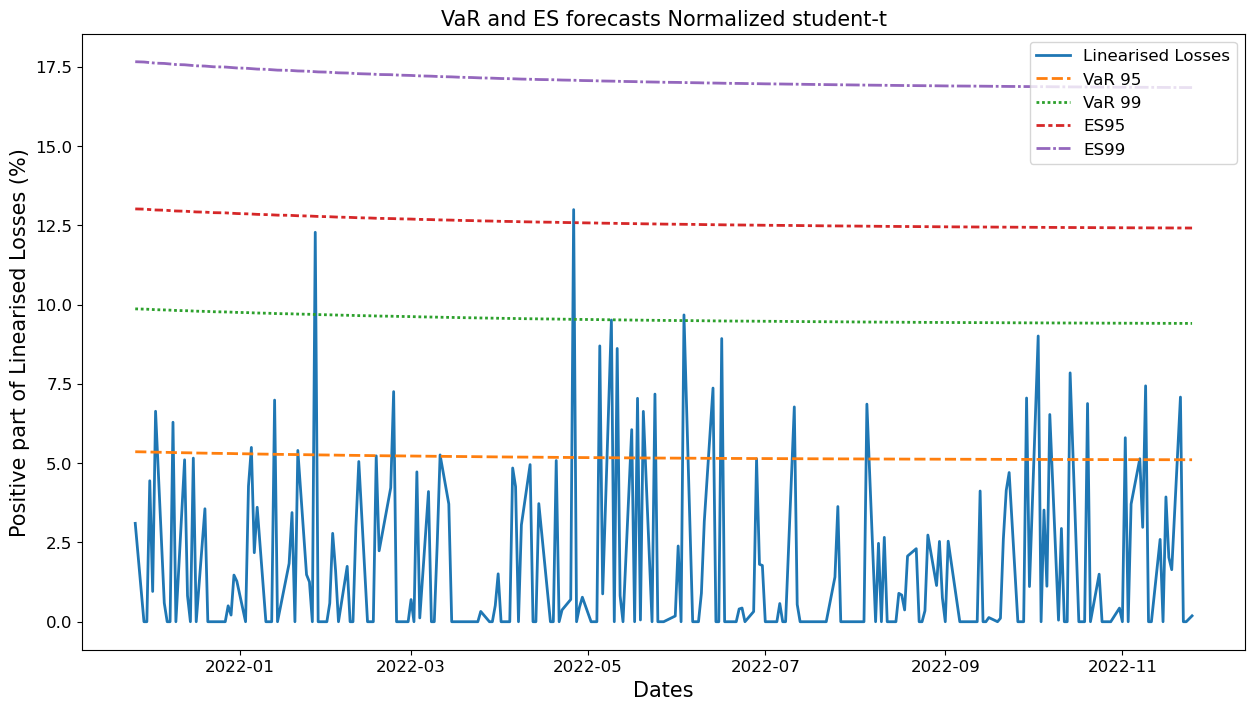

In [64]:
plt.figure(figsize=(15,8))
df_to_plot=pd.DataFrame({"Linearised Losses":y,"VaR 95":var95_t,"VaR 99":var99_t,"ES95":ES95_t,"ES99":ES99_t},
                        index=index)
sns.lineplot(data=df_to_plot,linewidth=2)
plt.title("VaR and ES forecasts Normalized student-t",size=15)
plt.legend(prop={'size': 12},loc="upper right")
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Dates",size=15)
plt.ylabel("Positive part of Linearised Losses (%)",size=15)

In [65]:
LRuc95=Unconditional_Test(test_data['linloss'],var95_t,0.95)
pval95=1-stats.chi2.cdf(LRuc95,1)
print(LRuc95)
print(pval95)

Number of violations: 30
Pi hat: 0.11904761904761904
18.5464994665759
1.6580945137789627e-05


In [66]:
LRuc99=Unconditional_Test(test_data['linloss'],var99_t,0.99)
pval99=1-stats.chi2.cdf(LRuc99,1)
print(LRuc99)
print(pval99)

Number of violations: 3
Pi hat: 0.011904761904761904
0.08704443664798996
0.7679687153509303


## Pareto Distribution
Using the parameters generated from (iii)

In [68]:
emp_objcdf2=sm.distributions.empirical_distribution.ECDF(std_resid)
emp_objcdf2(1)<=0.95

True

In [69]:
q95_pareto=u+beta/xi * (((1-0.95)/(1-emp_objcdf2(u)))**(-xi)-1)
q99_pareto=u+beta/xi * (((1-0.99)/(1-emp_objcdf2(u)))**(-xi)-1)

parES95=q95_pareto/(1-xi) + (beta-xi*u)/(1-xi)
parES99=q99_pareto/(1-xi) + (beta-xi*u)/(1-xi)

In [70]:
var95_pareto=mu+np.sqrt(volatilities[2266:])*q95_pareto
var99_pareto=mu+np.sqrt(volatilities[2266:])*q99_pareto

ES95_pareto=mu+np.sqrt(volatilities[2266:])*parES95
ES99_pareto=mu+np.sqrt(volatilities[2266:])*parES99

Text(0, 0.5, 'Positive part of Linearised Losses (%)')

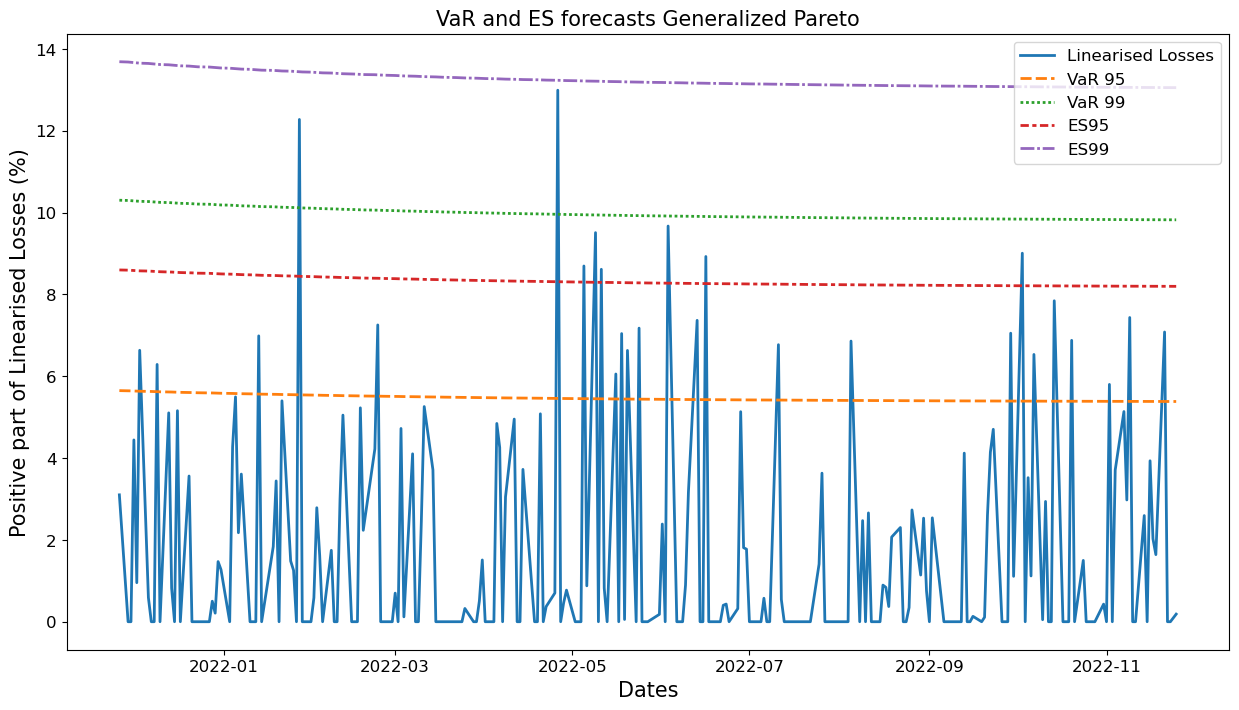

In [71]:
plt.figure(figsize=(15,8))
df_to_plot=pd.DataFrame({"Linearised Losses":y,"VaR 95":var95_pareto,"VaR 99":var99_pareto,"ES95":ES95_pareto,"ES99":ES99_pareto},
                        index=index)

sns.lineplot(data=df_to_plot,linewidth=2)

plt.title("VaR and ES forecasts Generalized Pareto",size=15)
plt.legend(prop={'size': 12},loc="upper right")
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Dates",size=15)
plt.ylabel("Positive part of Linearised Losses (%)",size=15)

In [72]:
LRuc95=Unconditional_Test(test_data['linloss'],var95_pareto,0.95)
pval95=1-stats.chi2.cdf(LRuc95,1)
print(LRuc95)
print(pval95)

Number of violations: 26
Pi hat: 0.10317460317460317
11.633226830413298
0.0006478407004301134


In [73]:
LRuc99=Unconditional_Test(test_data['linloss'],var99_pareto,0.99)
pval99=1-stats.chi2.cdf(LRuc99,1)
print(LRuc99)
print(pval99)

Number of violations: 2
Pi hat: 0.007936507936507936
0.11663621830875202
0.7327118118255211


## Using n one-day ahead forecasts


In [75]:
var=np.var(train_data['linloss'],ddof=1)
mu=res.params[0]
alpha0=res.params[1]
alpha1=res.params[2]
beta1=res.params[3]
volatilities=np.zeros(len(df_shift))
volatilities[0]=var
for i in range(1,len(train_data)+1):
    volatilities[i]=alpha0+alpha1*(train_data['linloss'].iloc[i-1]-mu)**2+beta1*volatilities[i-1]

C:\Users\default.EliteBook\AppData\Local\Temp\ipykernel_9644\1750297425.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu=res.params[0]
C:\Users\default.EliteBook\AppData\Local\Temp\ipykernel_9644\1750297425.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha0=res.params[1]
C:\Users\default.EliteBook\AppData\Local\Temp\ipykernel_9644\1750297425.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha1=res.params[2]
C:\Us

In [76]:
volatilities

array([12.15438906, 11.67526491, 11.61690362, ...,  0.        ,
        0.        ,  0.        ])

In [77]:
#now implement n 1-step ahead estimations of sigma using the training data
for i in range(0,len(test_data)-1):
    volatilities[len(train_data)+1+i]=alpha0 + alpha1 * (test_data['linloss'].iloc[i]-mu)**2 + beta1 * volatilities[i+len(train_data)]

Text(0, 0.5, 'Positive part of Linearised Losses (%)')

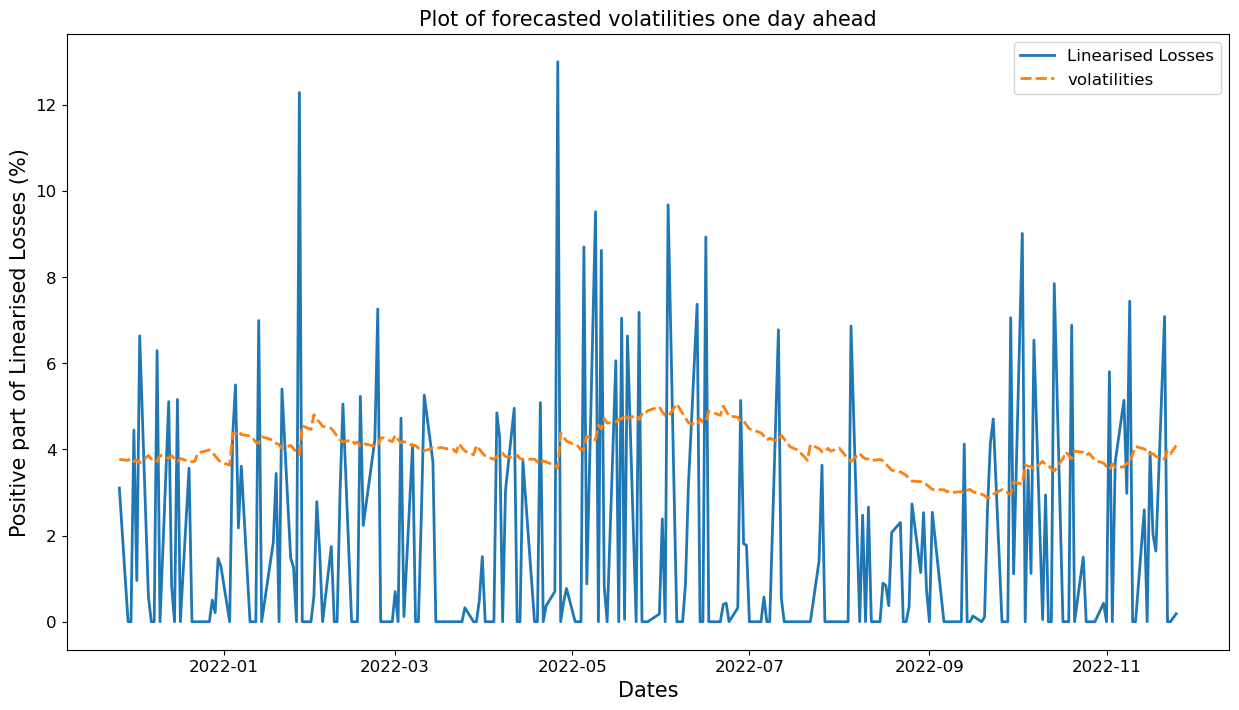

In [78]:
y=[i if i>0 else 0 for i in test_data['linloss']]
plt.figure(figsize=(15,8))
df_to_plot=pd.DataFrame({"Linearised Losses":y,"volatilities":np.sqrt(volatilities[2266:])},index=index)
sns.lineplot(data=df_to_plot,linewidth=2)
plt.title("Plot of forecasted volatilities one day ahead",size=15)
plt.legend(prop={'size': 12})
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Dates",size=15)
plt.ylabel("Positive part of Linearised Losses (%)",size=15)

In [79]:
#We assume that the residuals follow a standard normal distribution, so we can compute the quantiles directly
q95_norm=stats.norm.ppf(0.95)
q99_norm=stats.norm.ppf(0.99)

ZES95_norm=stats.norm.pdf(q95_norm)/(1-0.95)
ZES99_norm=stats.norm.pdf(q99_norm)/(1-0.99)

In [80]:
#now calculate the VaR and ES forecasts for test data time frame
var95_norm=mu+np.sqrt(volatilities[2266:])*q95_norm
var99_norm=mu+np.sqrt(volatilities[2266:])*q99_norm
ES95_norm=mu+np.sqrt(volatilities[2266:])*ZES95_norm
ES99_norm=mu+np.sqrt(volatilities[2266:])*ZES99_norm

Text(0, 0.5, 'Positive part of Linearised Losses (%)')

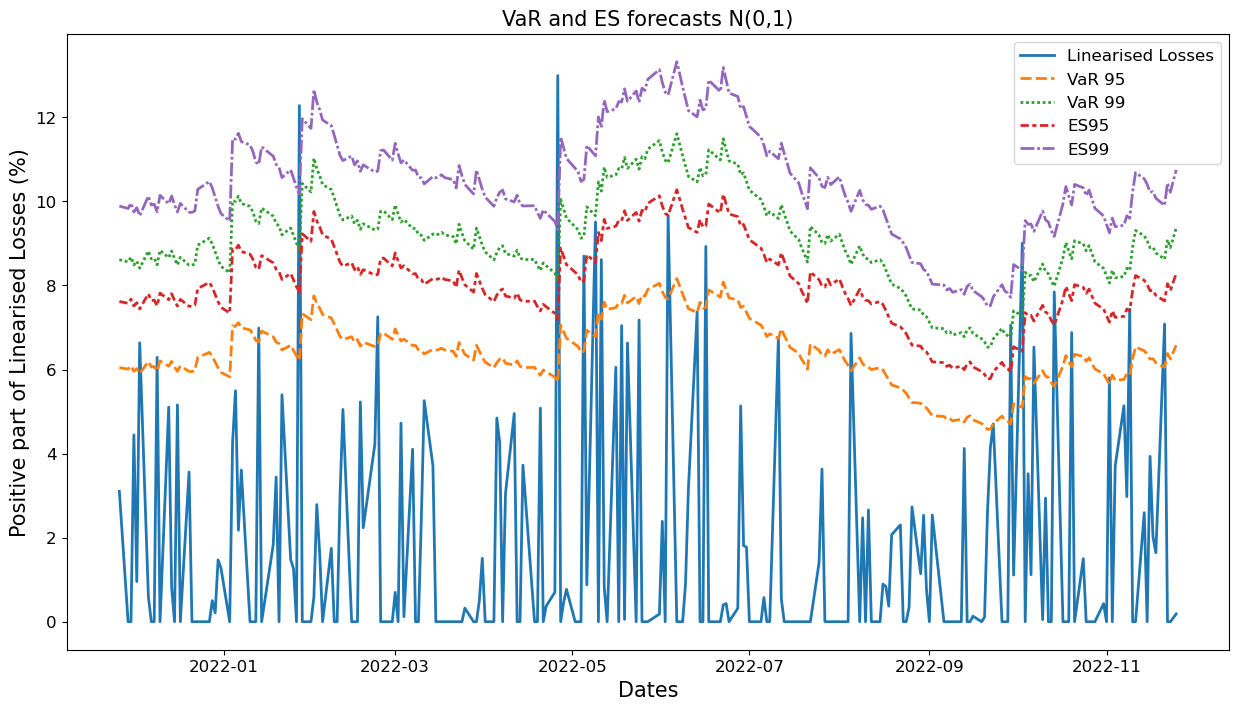

In [81]:
y=[i if i>0 else 0 for i in test_data['linloss']]
plt.figure(figsize=(15,8))
df_to_plot=pd.DataFrame({"Linearised Losses":y,"VaR 95":var95_norm,"VaR 99":var99_norm,"ES95":ES95_norm,"ES99":ES99_norm},
                        index=index)
sns.lineplot(data=df_to_plot,linewidth=2)
plt.title("VaR and ES forecasts N(0,1)",size=15)
plt.legend(prop={'size': 12})
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Dates",size=15)
plt.ylabel("Positive part of Linearised Losses (%)",size=15)

In [82]:
LRuc95=Unconditional_Test(test_data['linloss'],var95_norm,0.95)
pval95=1-stats.chi2.cdf(LRuc95,1)
print(LRuc95)
print(pval95)

Number of violations: 22
Pi hat: 0.0873015873015873
6.097225401327241
0.013539430301558353


In [83]:
LRuc99=Unconditional_Test(test_data['linloss'],var99_norm,0.99)
pval99=1-stats.chi2.cdf(LRuc99,1)
print(LRuc99)
print(pval99)

Number of violations: 4
Pi hat: 0.015873015873015872
0.745080952274408
0.3880381133603774


## Student T distribution

In [85]:
#using formulas in part 2 slide 59
q95_t=stats.t.ppf(0.95,df=df,scale=scale)
q99_t=stats.t.ppf(0.99,df=df,scale=scale)

tES95=stats.t.pdf(q95_t,df=df,scale=scale)/(1-0.95)*(df+q95_t**2)/(df-1)
tES99=stats.t.pdf(q99_t,df=df,scale=scale)/(1-0.99)*(df+q99_t**2)/(df-1)

In [86]:
print(stats.t.pdf(q99_t,df=df,scale=scale))
print(stats.t.pdf(q99_t,df=df))

0.011384299853695391
0.03074591479033


In [87]:
print(q95_t)
print(q99_t)
print(tES95)
print(tES99)
print(df)
print(scale)

1.4627582210979186
2.6586180783293125
3.4953128729644973
4.727410924831054
3.559260687859319
0.6618803164638942


In [88]:
#now calculate the VaR and ES forecasts for test data time frame
var95_t=mu+np.sqrt(volatilities[2266:])*q95_t
var99_t=mu+np.sqrt(volatilities[2266:])*q99_t
ES95_t=mu+np.sqrt(volatilities[2266:])*tES95
ES99_t=mu+np.sqrt(volatilities[2266:])*tES99

Text(0, 0.5, 'Positive part of Linearised Losses (%)')

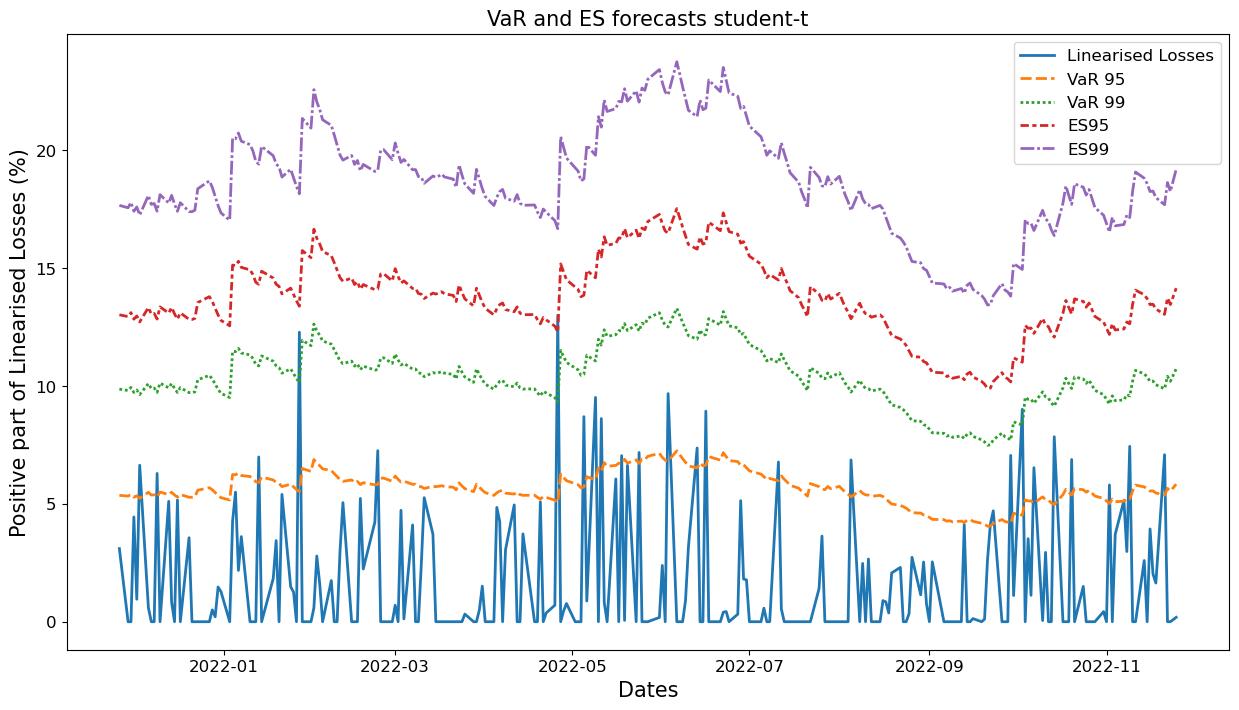

In [89]:
plt.figure(figsize=(15,8))
df_to_plot=pd.DataFrame({"Linearised Losses":y,"VaR 95":var95_t,"VaR 99":var99_t,"ES95":ES95_t,"ES99":ES99_t},
                        index=index)
sns.lineplot(data=df_to_plot,linewidth=2)
plt.title("VaR and ES forecasts student-t",size=15)
plt.legend(prop={'size': 12})
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Dates",size=15)
plt.ylabel("Positive part of Linearised Losses (%)",size=15)

In [90]:
LRuc95=Unconditional_Test(test_data['linloss'],var95_t,0.95)
pval95=1-stats.chi2.cdf(LRuc95,1)
print(LRuc95)
print(pval95)

Number of violations: 27
Pi hat: 0.10714285714285714
13.23963689677873
0.00027409099916020363


In [91]:
LRuc99=Unconditional_Test(test_data['linloss'],var99_t,0.99)
pval99=1-stats.chi2.cdf(LRuc99,1)
print(LRuc99)
print(pval99)

Number of violations: 3
Pi hat: 0.011904761904761904
0.08704443664798996
0.7679687153509303


## Pareto

In [93]:
emp_objcdf2=sm.distributions.empirical_distribution.ECDF(std_resid)
emp_objcdf2(1)<=0.95

True

In [94]:
q95_pareto=u+beta/xi * (((1-0.95)/(1-emp_objcdf2(u)))**(-xi)-1)
q99_pareto=u+beta/xi * (((1-0.99)/(1-emp_objcdf2(u)))**(-xi)-1)

parES95=q95_pareto/(1-xi) + (beta-xi*u)/(1-xi)
parES99=q99_pareto/(1-xi) + (beta-xi*u)/(1-xi)

In [173]:
print(q95_pareto)
print(q99_pareto)
print(parES95)
print(parES99)
print(u)
print(mu)
print(beta)
print(xi)

1.5397949719688218
2.775435519582981
2.322926883482991
3.6743974877364676
1
-0.1506096273719729
0.6697482423753545
0.0857066785431854


In [72]:
var95_pareto=mu+np.sqrt(volatilities[2266:])*q95_pareto
var99_pareto=mu+np.sqrt(volatilities[2266:])*q99_pareto

ES95_pareto=mu+np.sqrt(volatilities[2266:])*parES95
ES99_pareto=mu+np.sqrt(volatilities[2266:])*parES99

Text(0, 0.5, 'Positive part of Linearised Losses (%)')

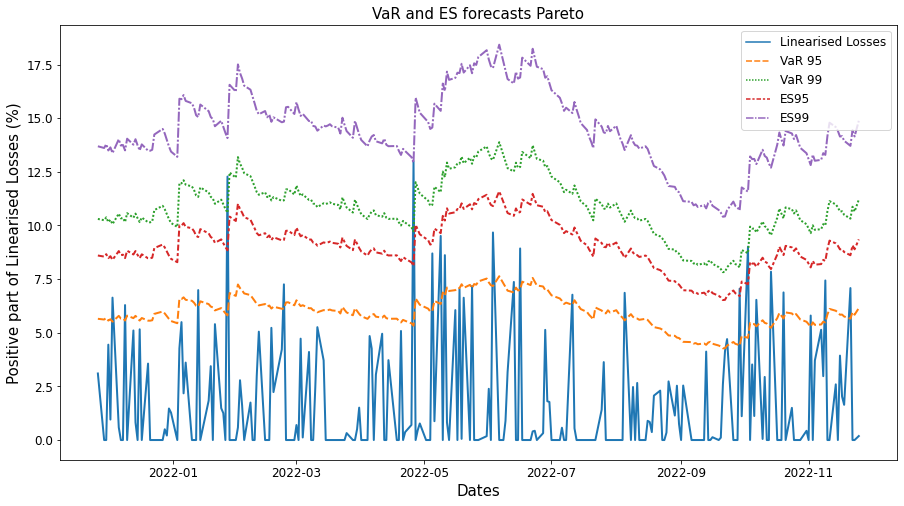

In [73]:
plt.figure(figsize=(15,8))
df_to_plot=pd.DataFrame({"Linearised Losses":y,"VaR 95":var95_pareto,"VaR 99":var99_pareto,"ES95":ES95_pareto,"ES99":ES99_pareto},
                        index=index)
sns.lineplot(data=df_to_plot,linewidth=2)
plt.title("VaR and ES forecasts Pareto",size=15)
plt.legend(prop={'size': 12})
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Dates",size=15)
plt.ylabel("Positive part of Linearised Losses (%)",size=15)

In [74]:
LRuc95=Unconditional_Test(test_data['linloss'],var95_pareto,0.95)
pval95=1-stats.chi2.cdf(LRuc95,1)
print(LRuc95)
print(pval95)

Number of violations: 24
Pi hat: 0.09523809523809523
8.680821925483624
0.0032157592747376063


In [75]:
LRuc99=Unconditional_Test(test_data['linloss'],var99_pareto,0.99)
pval99=1-stats.chi2.cdf(LRuc99,1)
print(LRuc99)
print(pval99)

Number of violations: 3
Pi hat: 0.011904761904761904
0.08704443664798996
0.7679687153509303
